# Woulda, Coulda, Shoulda - DRAW 
 
 - *Woulda, Coulda, Shoulda : Counterfactually-Guided Policy Search*, **l. Buesing, T. Weber, Y. Zwols et al.** 2018
 - *DRAW: A Recurrent Neural Network For Image Generation* **K. Gregor, I. Danihelka, Alex Graves, et al** https://arxiv.org/abs/1502.04623
 <br> 
 <br>
<img align="left"src="image/draw.png" width=800 />


**<a id="toc"></a>Table of Content**



[1. Draw : A Recurrent Neural Network For Image Generation](#draw)<br>
 - [1.1 Train model](#train)<br>
 - [1.2 Results](#results)<br>
 - [1.3 Add Constraints](#draw)<br>
 
[2. Sanity Check when providing initial state](#sanity)<br>

_______________________________

Packages

In [2]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch import tensor
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from rollout import rollout
from sokoban_wrappers import make_sokoban, render_po, render_full

from DRAW.draw_model import DRAWModel, train_draw, params
import torch.optim as optim

_______________________________

### Data Collection $\hat{h}_T$ under policy $\mu$

The data $\hat{h}_T$ is collected under a uniform random policy $\mu$. Let's do a rollout of an episode with T=50 :

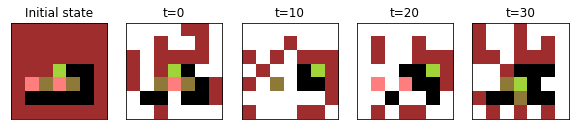

In [2]:
history = rollout(T=50, env_name='Sokoban-small-v0', po_wrapper=True, action_wrapper=True, mask_proba=0.7)

fig, ax = plt.subplots(1,5, figsize=(10,10))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;

ax[0].imshow(render_full(history['initial_state']))
ax[0].set_title('Initial state')
for it, i in enumerate(range(0,40,10)):
    arr = history['obs'][i]
    ax[it+1].imshow(render_po(arr))
    ax[it+1].set_title('t={}'.format(i))

## <a id="draw"></a>Draw : A Recurrent Neural Network For Image Generation <span  style="float:right">[[toc]](#toc)</span >

*DRAW: A Recurrent Neural Network For Image Generation* K. Gregor, I. Danihelka, Alex Graves, et al https://arxiv.org/abs/1502.04623

The only part of the model that remains to be identified is the initial state distribution $p(U_{s_1})$. The authors proposed to use the DRAW model, a convolutional and recurrent neural network for image generation : 
1. first the obersvational history $\hat{h}_T$ is summarized by a convolutional LSTM.
2. Fed into a DRAW model to generate $U_{s_1} \in \{0,1\}^{10 \times 10 \times 7}$

**Load the data**

For convenience, we tranpose the data to have the shape (batch, T, channel, W, H).

In [3]:
files = sorted(os.listdir('DRAW/data/7x7/'))
max_folder = min(len(files), 10)
split = max_folder - int(0.1*max_folder)

data_train = np.load('DRAW/data/7x7/sokoban_000.npy')
data_test = np.load('DRAW/data/7x7/sokoban_{}.npy'.format(str(split).zfill(3)))

for i in range(1,split):
    data_train = np.concatenate([data_train, np.load('DRAW/data/7x7/sokoban_{}.npy'.format(str(i).zfill(3)))], axis=0)
for i in range(split, max_folder):
    data_test = np.concatenate([data_test, np.load('DRAW/data/7x7/sokoban_{}.npy'.format(str(i).zfill(3)))], axis=0)
    
data_train = np.transpose(data_train, (0, 1, 4, 2, 3))
data_test = np.transpose(data_test, (0, 1, 4, 2, 3))
print('Train data :', data_train.shape, '\nTest data  :', data_test.shape)

Train data : (450, 51, 7, 7, 7) 
Test data  : (100, 51, 7, 7, 7)


__________________________________

### <a id="train"></a>Train Model

Choose the episode length history T.

In [8]:
T, channel, W, H =  50, 7, 7, 7 

# Dictionary storing network parameters.
params['T'] = T ; params['A'] = H ; params['B'] = W ; params['channel'] = channel
params['z_size'] = 50 ; params['batch_size'] = 8
params['read_N'] =  params['write_N'] = H
params['conv'] = True

# Use GPU is available else use CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
params['device'] = device ; print(device, " will be used.")

cuda:0  will be used.


In [9]:
draw_model = DRAWModel(params).to(device)
draw_optimizer = optim.Adam(draw_model.parameters(), lr=params['learning_rate'], betas=(params['beta1'], 0.999))

dataloader_train = torch.utils.data.DataLoader(data_train[:, :(T+1),  :, :, :], 
                                               batch_size=params['batch_size'], shuffle=True)
dataloader_test = torch.utils.data.DataLoader(data_test[:, :(T+1), :, :, :], 
                                              batch_size=params['batch_size'], shuffle=False)

Conv LSTM as encoder


In [10]:
checkpoint = False
if checkpoint :
    model_path = 'DRAW/checkpoint/7x7final/{}/model_epoch_50'.format(T)
    draw_model.load_state_dict(torch.load(model_path)['model'])
    draw_optimizer.load_state_dict(torch.load(model_path)['optimizer'])    
    params = torch.load(model_path)['params']

In [11]:
#train_draw(draw_model, draw_optimizer, params, dataloader, dataloader_test, 'DRAW/checkpoint/7x750')

## <a id="results"></a> Results

In [52]:
T, channel, W, H = 1, 7,7,7
device = 'cpu'

params['T'] = T ; params['z_size'] = 50
params['A'] = H ; params['B'] = W ; params['channel'] = channel
params['read_N'] =  params['write_N'] = H
params['conv'] = True ; params['device'] = device

draw_model = DRAWModel(params).to(device)
optimizer = optim.Adam(draw_model.parameters(), lr=params['learning_rate'], betas=(params['beta1'], 0.999))

checkpoint = True
model_path = 'DRAW/checkpoint/7x7/{}/model_epoch_30'.format(T)

if checkpoint :
    draw_model.load_state_dict(torch.load(model_path)['model'])
    optimizer.load_state_dict(torch.load(model_path)['optimizer'])    
    params = torch.load(model_path)['params']

Conv LSTM as encoder


In [53]:
def fix_player(arr):
    mininum, maximum = np.min(arr[:,:,:]), np.max(arr[:,:,:])
    ind = np.unravel_index(np.argmax(arr[5, :,:], axis=None), arr[5, :,:].shape)
    arr[5, :, :] = mininum
    arr[6, :, :] = mininum
    arr[3, :, :] = mininum
    arr[5, ind[0], ind[1]] = np.max(arr[:,:,:])+1
    return arr

def fix_item(arr, item):
    mininum, maximum = np.min(arr[:,:,:]), np.max(arr[:,:,:])
    indices = np.argwhere(arr.argmax(0)==item)
    if len(indices) == 2:
        pass
    elif len(indices) > 2:
        l = []
        for ind in indices:
            l.append((ind, arr[item, ind[0], ind[1]]))
        l = sorted(l, key = lambda tup : tup[1])
        arr[item, :,:] = mininum
        for ind, val  in l[-2:]:
            arr[item, ind[0],ind[1]] = maximum
    elif len(indices) == 1:
        ind = indices[0]
        arr_copy = arr[item, :, :].copy()
        arr[item, :,:] = mininum
        arr[item,ind[0], ind[1]] = maximum
        arr_copy[ind[0], ind[1]] = mininum 
        ind = np.unravel_index(np.argmax(arr_copy, axis=None), arr_copy.shape)
        arr[item, ind[0],ind[1]] = maximum
    else :
        arr_copy = arr[item, :, :].copy()
        arr[item, :,:] = mininum
        ind = np.unravel_index(np.argmax(arr_copy, axis=None), arr_copy.shape)
        arr[item, ind[0],ind[1]] = maximum
        arr_copy[ind[0], ind[1]] = mininum 
        ind = np.unravel_index(np.argmax(arr_copy, axis=None), arr_copy.shape)
        arr[item, ind[0],ind[1]] = maximum
    return arr

#### On train dataset

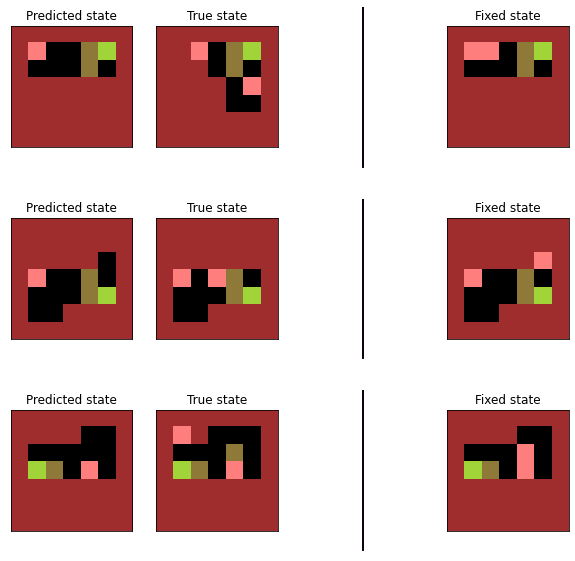

In [54]:
draw_model.eval()
fig, ax = plt.subplots(3,4, figsize=(10,10))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
    
for i, idx in enumerate([1, 11, 22]):
    with torch.no_grad():
        
        draw_model.cs = [0] * draw_model.Z
        data = data_train[idx,1:(T+1),:].reshape(T,7,7,7)
        draw_model.forward(torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device))

        arr = draw_model.cs[-1].reshape(7,7,7)#, (1,2,0))
        arr = torch.softmax(arr, dim=0).cpu().data.numpy()
        ax[i, 0].imshow(render_full(arr.argmax(0))) ; ax[i, 0].set_title('Predicted state')

        #arr = predict_initial_state(draw_model, data)
        arr = fix_player(arr)
        arr = fix_item(arr,2)
        arr = fix_item(arr,4)
        ax[i, 3].imshow(render_full(arr.argmax(0))) ; ax[i, 3].set_title('Fixed state')

        ax[i, 2].imshow(np.zeros((100,1))) ; 

        arr = data_train[idx,0]
        ax[i, 1].imshow(render_full(arr.argmax(0))) ; ax[i,1].set_title('True state')

**On test dataset**

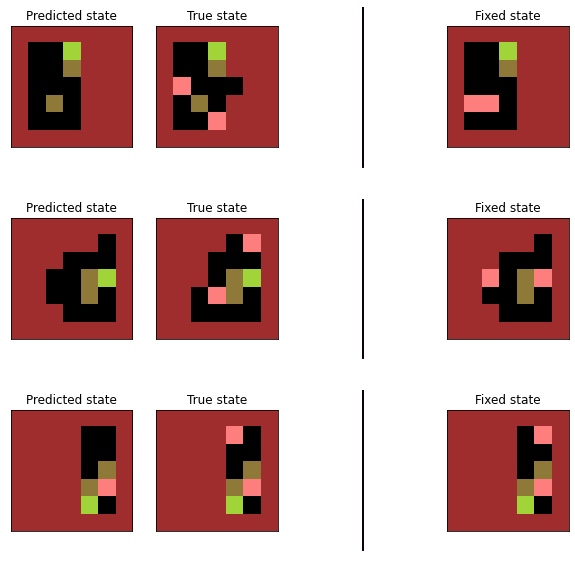

In [55]:
draw_model.eval()
fig, ax = plt.subplots(3,4, figsize=(10,10))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
    
for i, idx in enumerate([11, 22, 33]):
    with torch.no_grad():
        draw_model.cs = [0] * draw_model.Z
        data = data_test[idx,1:(T+1),:].reshape(T,7,7,7)
        draw_model.forward(torch.tensor(data, dtype = torch.float32).unsqueeze(0).to(device))

        arr = draw_model.cs[-1].reshape(7,7,7).cpu().data.numpy()#, (1,2,0))
        ax[i, 0].imshow(render_full(arr.argmax(0))) ; ax[i, 0].set_title('Predicted state')
        
        arr = fix_player(arr)
        arr = fix_item(arr,2)
        arr = fix_item(arr,4)
        ax[i, 3].imshow(render_full(arr.argmax(0))) ; ax[i, 3].set_title('Fixed state')
        ax[i, 2].imshow(np.zeros((100,1))) ; 


        arr = data_test[idx,0]
        ax[i, 1].imshow(render_full(arr.argmax(0))) ; ax[i, 1].set_title('True state')

**Undersetand where the loss come from**

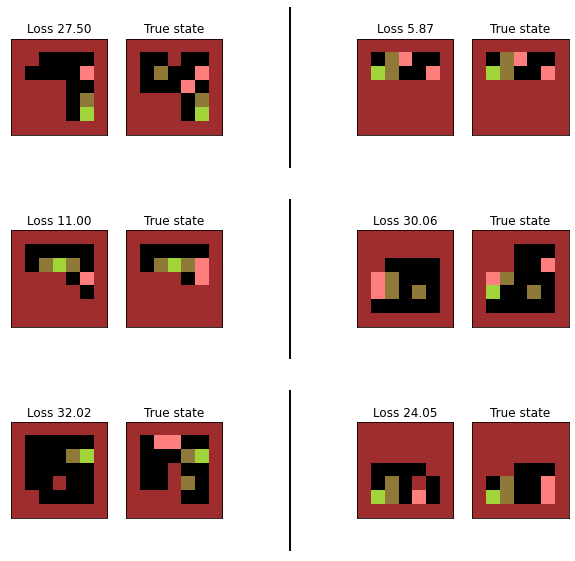

In [207]:
fig, ax = plt.subplots(3,5, figsize=(10,10))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
draw_model.eval()
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size=1, shuffle=True)

j = 0
for i, data_batch in enumerate(dataloader_test, 0):
    if j > 5 :
        break

    data = torch.tensor(data_batch[:,1:,:,:,:], dtype = torch.float32).to(device) 
    data_tr = torch.tensor(data_batch[:,0], dtype = torch.float32).to(device)        
    
    draw_model.forward(data)
    criterion = nn.BCELoss()
    x_recon = torch.sigmoid(draw_model.cs[-1])
    loss = criterion(x_recon, data_tr) * draw_model.A * draw_model.B * draw_model.channel
    loss_val = loss.cpu().data.numpy()
    
    arr = draw_model.cs[-1].reshape(7,7,7) ; arr = torch.sigmoid(arr).cpu().data.numpy()
    ax[j//2,(j%2)*3].imshow(render_full(arr.argmax(0))) ; ax[j//2,(j%2)*3].set_title('Loss {:.2f}'.format(loss_val))
    ax[j//2,(j%2)*3+1].imshow(render_full(data_batch[0,0].argmax(0))) ; ax[j//2,(j%2)*3+1].set_title('True state')   
    j += 1
    
    for i in range(j//2):
        ax[i, 2].imshow(np.zeros((100,1))) ; 

In [60]:
def predict_initial_state(draw_model, history, transpose = False, fixed = False):
    draw_model.eval()
    with torch.no_grad():
        draw_model.cs = [0] * draw_model.Z
        if transpose :
            history = np.transpose(history.reshape(-1,7,7,7), (0,3,1,2))
        else :
            history = history.reshape(-1,7,7,7)
        draw_model.forward(torch.tensor(history.reshape(-1,7,7,7), dtype = torch.float32).unsqueeze(0).to(device))
        arr = draw_model.cs[-1].reshape(7,7,7).cpu().data.numpy()#, (1,2,0))
        if fixed :
            arr = fix_player(arr)
            arr = fix_item(arr,2)
            arr = fix_item(arr,4)
        return arr

__________________

##  <a id="sanity"></a> Sanity Check when providing initial state

Remarks : 
- if only 1 target is missing, by default, the first reward would be +1, and if agents push one box onto the last target, the game finishes with reward +12. <br> **SOLUTION** : if 1 missing target : epr = min(1, epr-1).
- if both targets are missing , epr is 11. <br> **SOLUTION** : return 0 as epr.
- if too many targets, the game can be solved, first reward of -1 and the +1 for the two next boxes on targets without the +12 bonus at the end. <br> **SOLUTION** : epr = epr + 1
- if too many or too few boxes, nothing changes (only targets count) in the reward. <br> **SOLUTION** : don't do anything
- If there is no agents, the game crashes. <br> **SOLUTION** : if no player, return 0 as epr.
- If there is several agents, one is choose by default to be the main player. <br> **SOLUTION** : if several players, return 0 as epr.

In [162]:
def quality_check(initial_state):
    nb_agents = np.where(initial_state==5)
    nb_boxes = np.where(initial_state==4)
    nb_targets = np.where(initial_state==2)
    return len(nb_agents[0]), len(nb_boxes[0]), len(nb_targets[0])

def start_allowed(initial_state):
    ag, _ , _= quality_check(init_state)
    if ag == 0 or ag > 1 : 
        return False
    else :
        return True
def reward_correction(initial_state, reward):
    ag, bx, tg = quality_check(init_state)
    if tg == 1 : 
        return min(1, reward-1)
    elif tg < 1 :
        return 0
    elif tg > 2 :
        return epr+1
    elif ag == 0 :
        return 0
    elif ag > 1 : 
        return 0
    else :
        return reward

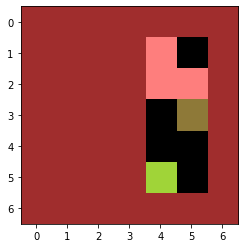

In [166]:
init_state = np.array([
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 0],
       [0, 0, 0, 0, 2, 2, 0],
       [0, 0, 0, 0, 1, 4, 0],
       [0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 5, 1, 0],
       [0, 0, 0, 0, 0, 0, 0]])
plt.imshow(render_full(init_state))

In [167]:
import sys ; sys.path.append('C:/Users/damie/Desktop/WCS/baby_a3c')
from test_a3c import run_test, create_env, SokobanPolicy

In [163]:
env = create_env('Sokoban-small-v0', nb_room = 0,  mask_proba=0.7)
state = torch.tensor(env.reset(**{'array':init_state}))
episode_length, epr, done  = 0, 0, True # bookkeeping

import time
try :
    for i in range(10):
        env.render()
        action = input()
        state, reward, done, _ = env.step(int(action))
        time.sleep(1)
        print(reward)
except :
    pass
env.close()

_____________________